In [1]:
import torch
import time
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from copy import deepcopy 
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
DATA_DIR = "data/"
STOCKFISH_DIR = 'stockfish/'
ARCHIVE_DIR = DATA_DIR + 'archives/'
BITBOARD_DIR = DATA_DIR + 'bitboards/'
ELITE_DATA_BASE_URL  = "https://database.nikonoel.fr/"
STOCKFISH_DOWNSTREAM = "https://github.com/official-stockfish/Stockfish/releases/latest/download/"

SAMPLE_ZIP = "lichess_elite_2021-11.zip"
SAMPLE_PGN = "lichess_elite_2021-11.pgn"
SAMPLE_BITBOARD = "elite_bitboard.csv"
ELITE_DATA_SAMPLE_URL = ELITE_DATA_BASE_URL + SAMPLE_ZIP
SAMPLE_ZIP_FILE = ARCHIVE_DIR + SAMPLE_ZIP
SAMPLE_PGN_FILE  = DATA_DIR + SAMPLE_PGN

STOCKFISH_AVX512_TAR = "stockfish-ubuntu-x86-64-avx512.tar"
STOCKFISH_AVX512 = "stockfish-ubuntu-x86-64-avx512"
STOCKFISH_AVX512_URL = STOCKFISH_DOWNSTREAM + STOCKFISH_AVX512_TAR
STOCKFISH_AVX512_EXE = STOCKFISH_DIR + STOCKFISH_AVX512

SAMPLE_BITBOARD_FILE = BITBOARD_DIR + SAMPLE_BITBOARD

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
class BitboardDrawDataset(Dataset):
    def __init__(self, bitboard_file):
        bitboards_df = pd.read_csv(bitboard_file, sep=";", dtype="uint64", usecols=range(12))
        metadata_df = pd.read_csv(bitboard_file, sep=";", dtype="int64", usecols=range(12, 14))

        self.bitboards = np.unpackbits(np.ascontiguousarray(bitboards_df.to_numpy()).view(np.uint8), axis=1).astype(np.single)
        self.is_draw = metadata_df['draw'].to_numpy(dtype=np.single)
        self.length = self.is_draw.size

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return self.bitboards[idx], self.is_draw[idx]

In [4]:
class SimpleModel(nn.Module):

    def __init__(self, neurons=256):
        super().__init__()
        self.neurons = neurons
        self.model = nn.Sequential(
            nn.Linear(768, neurons),
            # nn.ReLU(),
            # nn.Linear(1024, neurons),
            nn.ReLU(),
            nn.Linear(neurons, 1)
        )

    def forward(self, x):
        return self.model.forward(x)

In [5]:
def timeit(f):

    def timed(*args, **kw):

        ts = time.time()
        result = f(*args, **kw)
        te = time.time()

        print(f"Took: {te-ts:.2f}s")
        return result
    return timed

class Train:
    
    def __init__(self, train_file, validate_file):
        # self.train_dataset, self.validate_dataset = random_split(BitboardDrawDataset(data_file), [90000, 10000])
        self.train_dataset, self.validate_dataset = BitboardDrawDataset(train_file), BitboardDrawDataset(validate_file)
        self.train_dataloader = DataLoader(self.train_dataset, batch_size=32, shuffle=True, pin_memory=True, pin_memory_device=device.type)
        self.validate_dataloader = DataLoader(self.validate_dataset, batch_size=32, shuffle=True, pin_memory=True, pin_memory_device=device.type)
        self.loss_fn = nn.BCEWithLogitsLoss()
        self.total_batches = len(self.train_dataloader)
        self.print_every = 100
        
    def train_one_epoch(self, model, optimizer, p=False) -> int:
        running_loss = 0.
        last_loss = 0.
    
        for i, data in enumerate(self.train_dataloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.unsqueeze(1).to(device)
    
            optimizer.zero_grad()

            outputs = model(inputs)
            
            loss = self.loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
            if i % self.print_every == self.print_every - 1:
                last_loss = running_loss / self.print_every
                if p: print(f"  batch {i+1} loss: {last_loss}")
                running_loss = 0.
            elif i == self.total_batches - 1:
                last_loss = running_loss / (i % self.print_every + 1)
                if p: print(f"  batch {i+1} loss: {last_loss}")
            
        return last_loss
    
    @timeit
    def train(self, model, optimizer, epochs, p=True):
        best_vloss = np.inf
        best_model = deepcopy(model.state_dict())
        best_epoch = 0
        best_acc = 0
    
        for epoch in range(1, epochs + 1):
            if p and epoch % 10 == 0 or epoch == 1: print(f'EPOCH {epoch}')
        
            # Make sure gradient tracking is on, and do a pass over the data
            model.train(True)
            avg_loss = self.train_one_epoch(model, optimizer)
        
            running_vloss = 0.0
            model.eval()
        
            with torch.no_grad():
                acc = 0
                for i, vdata in enumerate(self.validate_dataloader):
                    vinputs, vlabels = vdata
                    vinputs, vlabels = vinputs.to(device), vlabels.unsqueeze(1).to(device)
                    voutputs = model(vinputs)
                    pred = nn.functional.sigmoid(voutputs)
                    acc += (pred.round() == vlabels).sum()
                    vloss = self.loss_fn(voutputs, vlabels)
                    running_vloss += vloss
                    
            acc = (acc / len(self.validate_dataset)) * 100
            avg_vloss = running_vloss / (i + 1)
            if p and epoch % 10 == 0 or epoch == 1: print(f"LOSS train {avg_loss} valid {avg_vloss}")
            if p and epoch % 10 == 0 or epoch == 1: print(f"ACC {acc:.2f}%")
        
            if avg_vloss < best_vloss:
                best_vloss = avg_vloss
                best_model = deepcopy(model.state_dict())
                best_epoch = epoch
                best_acc = acc
                
        return best_model, best_epoch, best_acc
    
                
    def save_model(self, state_dict, neurons, epoch, lr, momentum, acc):
        model_path = f"models/model_{neurons}_{epoch}_{lr}_{momentum}_{acc:.2f}"
        torch.save(state_dict, model_path)
        
    
    def find_best_neuron(self, neurons, epochs, lr=0.1, momentum=0.9):
        for n in neurons:
            print(f"Model {n}")
            model = SimpleModel(n)
            model.to(device)
            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
            best_model, epoch, acc = self.train(model, optimizer, epochs)
            self.save_model(best_model, n, epoch, lr, momentum, acc)
            print("")
        

In [6]:
pipe = Train("data/bitboards/100k_0-1441.csv", "data/bitboards/10k_144100-144237.csv")

In [27]:
pipe.find_best_neuron([64, 128, 256, 512], 10)

Model 64
EPOCH 1
LOSS train 0.4685576379299164 valid 0.6932885050773621
ACC 63.48%
EPOCH 10
LOSS train 0.20692882359027862 valid 1.139052391052246
ACC 68.10%
Took: 40.99s

Model 128
EPOCH 1
LOSS train 0.4641104423999786 valid 0.6862139105796814
ACC 69.49%
EPOCH 10
LOSS train 0.21122819185256958 valid 1.2591369152069092
ACC 64.29%
Took: 41.16s

Model 256
EPOCH 1
LOSS train 0.4777806317806244 valid 0.6399534940719604
ACC 68.13%
EPOCH 10
LOSS train 0.2249453032016754 valid 1.2374744415283203
ACC 66.56%
Took: 41.69s

Model 512
EPOCH 1
LOSS train 0.5071118545532226 valid 0.6290889978408813
ACC 67.34%
EPOCH 10
LOSS train 0.2071860134601593 valid 1.2180514335632324
ACC 65.79%
Took: 43.48s



Acc: 87.04%


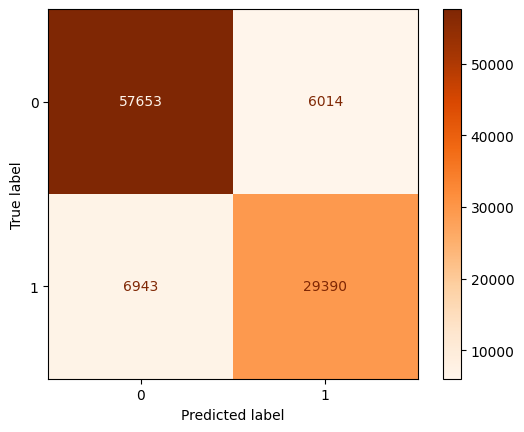

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score

validate_dataset = BitboardDrawDataset("data/bitboards/100k_0-1441.csv")
validate_dataloader = DataLoader(validate_dataset, batch_size=len(validate_dataset), pin_memory=True, pin_memory_device=device.type)

model = SimpleModel(128)
model.load_state_dict(torch.load("models/sgd/model_128_5_0.1_0.9_66.86"))
model.to(device)
model.eval()
with torch.no_grad():
    acc = 0
    vdata = next(iter(validate_dataloader))
    vinputs, vlabels = vdata
    vinputs, vlabels = vinputs.to(device), vlabels.unsqueeze(1).to(device)
    voutputs = model(vinputs)
    
    logits = nn.functional.sigmoid(voutputs)

    pred = logits > 0.5
    print(f"Acc: {(((pred == vlabels).sum() / len(validate_dataset)) * 100):.2f}%")
    
    cm = confusion_matrix(vdata[1].to('cpu'), pred.to('cpu'))
    ConfusionMatrixDisplay(cm).plot(cmap='Oranges')


In [28]:
arr = [(logits > k).cpu().numpy() for k in np.linspace(0, 1, 1000)]
acc_arr = [((i == vlabels.cpu().numpy()).sum() / 1000) for i in arr]
print(max(acc_arr))
acc_arr.index(max(acc_arr))

87.118


460

In [29]:
tparr = []
for i in arr:
    tparr.append(precision_score(vdata[1].to('cpu'), i))

/home/jan/venvs/nn-snake/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Best value: 1.00
Cutoff: 0.997


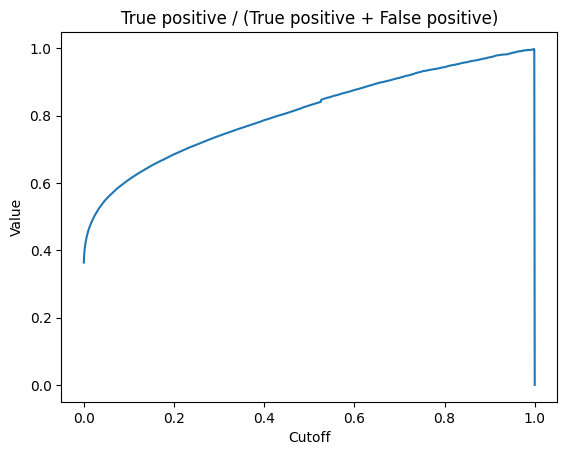

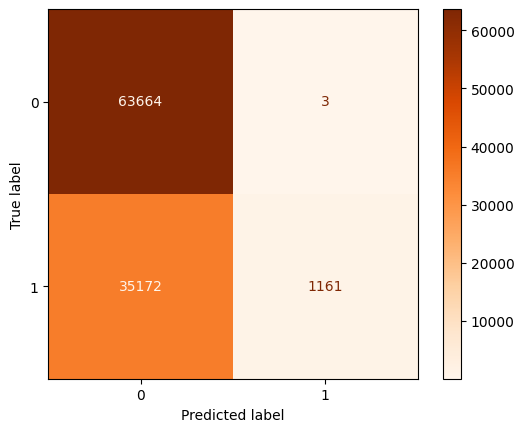

In [31]:
pred = logits > 0.997
plt.plot(np.linspace(0, 1, 1000), tparr)
plt.title("True positive / (True positive + False positive)")
plt.xlabel("Cutoff")
plt.ylabel("Value")
print(f"Best value: {max(tparr):.2f}\nCutoff: {tparr.index(max(tparr)) / 1000}")
cm = confusion_matrix(vdata[1].to('cpu'), pred.to('cpu'))
ConfusionMatrixDisplay(cm).plot(cmap='Oranges')

Best cutoff value: 0.61
Accuraccy : 68.40%


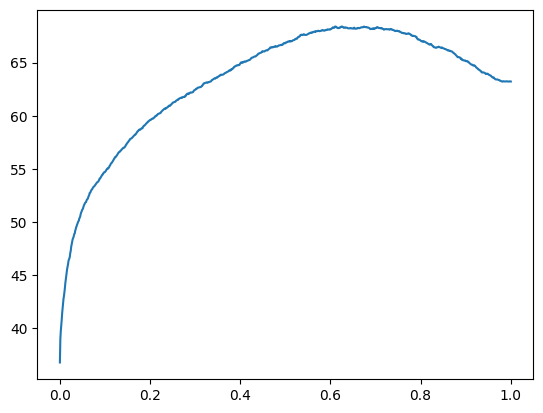

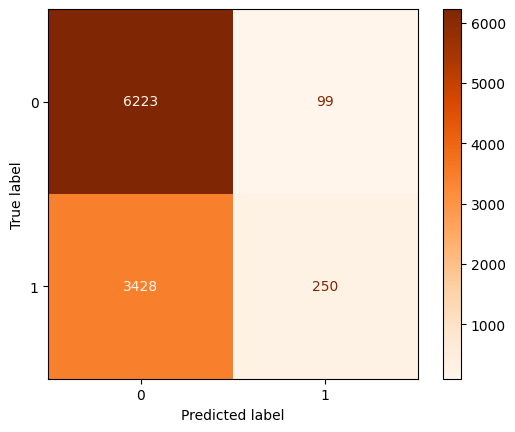

In [213]:
pred = logits > 0.918
plt.plot(np.linspace(0, 1, 1000), acc_arr)
print(f"Best cutoff value: {acc_arr.index(max(acc_arr)) / 1000}")
print(f"Accuraccy : {max(acc_arr):.2f}%")
cm = confusion_matrix(vdata[1].to('cpu'), pred.to('cpu'))
ConfusionMatrixDisplay(cm).plot(cmap='Oranges')

In [53]:
k10 = pd.read_csv("data/bitboards/10k_144100-144237.csv", sep=";", dtype="uint64", usecols=range(13, 14))
k100 = pd.read_csv("data/bitboards/100k_0-1441.csv", sep=";", dtype="uint64", usecols=range(12))

In [39]:
k10.map(lambda x: ";".join(np.char.mod('%d', np.unpackbits(np.array([x]).view(np.uint8))))).to_csv("dataset_bits.csv", sep=";", index=False)

k10.compare(k100)

In [57]:
bity = pd.read_csv("dataset_bits.csv", dtype="uint64", sep=";", header=None)

In [58]:
bity

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
9996,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
9997,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
9998,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


In [61]:
k10.rename(columns={"draw": 768})

,768
0,1
1,1
2,1
3,1
4,1
...,...
9995,1
9996,0
9997,0
9998,0


In [64]:
pd.concat([bity, k10.rename(columns={"draw": 768})], axis=1).to_csv("dataset_bits.csv", sep=";", index=False)

In [49]:
k10['draw']

0       1
1       1
2       1
3       1
4       1
       ..
9995    1
9996    0
9997    0
9998    0
9999    0
Name: draw, Length: 10000, dtype: uint64